In [213]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

In [214]:
data_path = './data/'
raw_train_df = pd.read_csv(data_path+'train.csv', index_col='PassengerId')
raw_test_df = pd.read_csv(data_path+'test.csv', index_col='PassengerId')

In [215]:
raw_train_df.info(), raw_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    f

(None, None)

In [216]:
raw_train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [217]:
# Define a custom estimator to extract the deck information from the cabin column
class ExtractDeck(BaseEstimator, TransformerMixin):
    def __init__(self, column, n_letters=1):
        self.column = column
        self.n_letters = n_letters

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Deck"] = X[self.column].str[:self.n_letters].fillna('M').replace(
            ['A','B','C'], 'ABC'
            ).replace(
                ['D','E'], 'DE'
                ).replace(
                    ['F','G'], 'FG'
                    )
        X.drop(columns=[self.column], inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Deck"]

In [218]:
# Define a custom estimator to extract the title from the name
class ExtractTitleDropName(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        self.title_map = {
            'Miss': 'Miss/Mrs/Ms', 
            'Mrs': 'Miss/Mrs/Ms',
            'Ms': 'Miss/Mrs/Ms', 
            'Mlle': 'Miss/Mrs/Ms', 
            'Lady': 'Miss/Mrs/Ms', 
            'Mme': 'Miss/Mrs/Ms', 
            'the Countess': 'Miss/Mrs/Ms', 
            'Dona': 'Miss/Mrs/Ms',
            'Dr': 'Dr/Military/Noble/Clergy',
            'Col': 'Dr/Military/Noble/Clergy',
            'Major': 'Dr/Military/Noble/Clergy',
            'Jonkheer': 'Dr/Military/Noble/Clergy',
            'Capt': 'Dr/Military/Noble/Clergy',
            'Sir': 'Dr/Military/Noble/Clergy',
            'Don': 'Dr/Military/Noble/Clergy',
            'Rev': 'Dr/Military/Noble/Clergy'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Family"] = X[self.column].apply(lambda name: name.split(',')[0].strip())
        X["Title"] = X[self.column].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        X["isMarried"] = X["Title"].map(lambda title: 1 if title == 'Mrs' else 0)
        X["Title"] = X["Title"].apply(lambda title: title if title not in self.title_map else self.title_map[title])
        X.drop(columns=[self.column], inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Family", "Title", "isMarried"]

In [219]:
# Define a custom estimator to extract the family size
class FamilySizeEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.group_map = {
            1: 'Alone',
            2: 'Small',
            3: 'Small',
            4: 'Small',
            5: 'Medium',
            6: 'Medium'
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Family_size"] = X[self.columns].sum(axis=1) + 1
        X["Family_size"] = X["Family_size"].apply(lambda size: 'Large' if size not in self.group_map else self.group_map[size])
        X.drop(columns=self.columns, inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Family_size"]

In [220]:
# Define a custom estimator to extract the ticket frequency
class TicketFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        freq_map = X[self.column].value_counts(normalize=False).to_dict()
        X["Ticket_freq"] = X[self.column].map(freq_map).values.reshape(-1,1)
        # X.drop(columns=self.column, inplace=True)
        return X

    def get_feature_names_out(self, input_features):
        return ["Ticket","Ticket_freq"]

In [221]:
# Pipelines
deck_pipeline = Pipeline([
    ('deck_extract', ExtractDeck(column='Cabin')),
    ('deck_encoder', OneHotEncoder(handle_unknown='ignore'))
])

embarked_pipeline = Pipeline([
    ('embarked_imputer', SimpleImputer(strategy='most_frequent', copy=False)),
    ('embarked_encoder', OneHotEncoder(handle_unknown='ignore'))
])

sex_pipeline = Pipeline([
    ('sex_encoder', OneHotEncoder(categories=[['female', 'male']], handle_unknown='ignore'))
])

age_pipeline = Pipeline([
    ('age_imputer', KNNImputer(n_neighbors=7)),
    ('age_discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

fare_pipeline = Pipeline([
    ('fare_scaler', StandardScaler()),
    ('fare_imputer', SimpleImputer(strategy='median')),
    ('fare_discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
])

name_pipeline = Pipeline([
    ('title_extractor', ExtractTitleDropName(column='Name')),
    ('title_encode', ColumnTransformer([
        ('encode_titles', OneHotEncoder(), ['Title'])
    ],verbose_feature_names_out=False,remainder='passthrough'))
])

family_pipeline = Pipeline([
    ('family_extractor', FamilySizeEncoder(columns=['SibSp','Parch'])),
    ('family_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', encoded_missing_value=-1, unknown_value=-1))
])

ticket_pipeline = Pipeline([
    ('ticket_freq', TicketFrequencyEncoder(column='Ticket'))
])

In [222]:
# Column Transformer
preprocessor = ColumnTransformer([
    ('fare', fare_pipeline, ['Fare']),                        # Standardize fare and impute with median
    ('deck', deck_pipeline, ['Cabin']),                       # Extract and encode deck info
    ('embarked', embarked_pipeline, ['Embarked']),            # One-hot-encode Embarked
    ('sex', sex_pipeline, ['Sex']),                           # Ordinal encode Sex
    ('name', name_pipeline, ['Name']),                        # Extract title and married status from name
    ('family', family_pipeline, ['SibSp', 'Parch']),          # Use SibSp + Parch + 1 as proxy for family size
    ('age', age_pipeline, ['Age']),                           # Impute Age
    ('ticket', ticket_pipeline, ['Ticket']),                  # Frequency encode tickets
], remainder='passthrough', verbose_feature_names_out=False,force_int_remainder_cols=False)

In [223]:
# Preprocess the data
train_df = preprocessor.fit_transform(raw_train_df)

# Convert to DataFrame with column names
train_df = pd.DataFrame(
    train_df,
    index=raw_train_df.index,
    columns=preprocessor.get_feature_names_out()
).convert_dtypes()

/home/nadir/.local/share/miniforge3/envs/data_science/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [224]:
train_df.to_csv(data_path+'train_preprocessed_new.csv')
train_df.head()

,Fare,Deck_ABC,Deck_DE,Deck_FG,Deck_M,Deck_T,Embarked_C,Embarked_Q,Embarked_S,Sex_female,...,Title_Miss/Mrs/Ms,Title_Mr,Family,isMarried,Family_size,Age,Ticket,Ticket_freq,Survived,Pclass
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,1,0,...,0,1,Braund,0,3,2,A/5 21171,1,0,3
2,8,1,0,0,0,0,1,0,0,1,...,1,0,Cumings,1,3,7,PC 17599,1,1,1
3,2,0,0,0,1,0,0,0,1,1,...,1,0,Heikkinen,0,0,3,STON/O2. 3101282,1,1,3
4,8,1,0,0,0,0,0,0,1,1,...,1,0,Futrelle,1,3,6,113803,2,1,1
5,3,0,0,0,1,0,0,0,1,0,...,0,1,Allen,0,0,6,373450,1,0,3


In [225]:
# Add fictitious survived column to test
raw_test_df['Survived'] = 0

# Preprocess the data
test_df = preprocessor.transform(raw_test_df)

# Convert to DataFrame with column names
test_df = pd.DataFrame(
    test_df,
    index=raw_test_df.index,
    columns=preprocessor.get_feature_names_out()
).convert_dtypes()

/home/nadir/.local/share/miniforge3/envs/data_science/lib/python3.12/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [226]:
class FamilyTicketSurvivalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.family_col = cols['family']
        self.ticket_col = cols['ticket']
        self.target_col = cols['survived']
        self.family_survival_rates = {}
        self.ticket_survival_rates = {}
    
    def fit(self, X, y=None):
        data = X.copy()
        
        # Compute family survival rates (ignoring families with only one member in train set)
        family_counts = data[self.family_col].value_counts()
        valid_families = family_counts[family_counts > 1].index
        self.family_survival_rates = data[data[self.family_col].isin(valid_families)]\
            .groupby(self.family_col)[self.target_col].mean().to_dict()
        
        # Compute ticket survival rates (ignoring tickets with only one passenger in train set)
        ticket_counts = data[self.ticket_col].value_counts()
        valid_tickets = ticket_counts[ticket_counts > 1].index
        self.ticket_survival_rates = data[data[self.ticket_col].isin(valid_tickets)]\
            .groupby(self.ticket_col)[self.target_col].mean().to_dict()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Apply family survival rates
        X['FamilySurvivalRate'] = X[self.family_col].map(self.family_survival_rates)
        X['FamilySurvivalRateNA'] = X[self.family_col].apply(lambda fam: 1 if pd.isna(self.family_survival_rates.get(fam)) else 0)
        
        # Apply ticket survival rates
        X['TicketSurvivalRate'] = X[self.ticket_col].map(self.ticket_survival_rates)
        X['TicketSurvivalRateNA'] = X[self.ticket_col].apply(lambda t: 1 if pd.isna(self.ticket_survival_rates.get(t)) else 0)
        
        # Fill missing survival rates with NaN (optional: you can replace them with a default value like 0.5)
        X['FamilySurvivalRate'] = X['FamilySurvivalRate'].fillna(0)
        X['TicketSurvivalRate'] = X['TicketSurvivalRate'].fillna(0)
        
        X['SurvivalRate'] = (X['FamilySurvivalRate']+X['TicketSurvivalRate'])/2
        X['SurvivalRateNA'] = (X['FamilySurvivalRateNA']+X['TicketSurvivalRateNA'])/2
        
        X.drop(columns=['FamilySurvivalRate','FamilySurvivalRateNA','TicketSurvivalRate','TicketSurvivalRateNA', 'Ticket','Family'],inplace=True)
        
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['SurvivalRate', 'SurvivalRateNA']

In [227]:
fam_transf = FamilyTicketSurvivalEncoder(cols={'family': 'Family', 'ticket': 'Ticket', 'survived': 'Survived'})
train_df = fam_transf.fit_transform(train_df)
test_df = fam_transf.transform(test_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Fare                            891 non-null    Int64  
 1   Deck_ABC                        891 non-null    Int64  
 2   Deck_DE                         891 non-null    Int64  
 3   Deck_FG                         891 non-null    Int64  
 4   Deck_M                          891 non-null    Int64  
 5   Deck_T                          891 non-null    Int64  
 6   Embarked_C                      891 non-null    Int64  
 7   Embarked_Q                      891 non-null    Int64  
 8   Embarked_S                      891 non-null    Int64  
 9   Sex_female                      891 non-null    Int64  
 10  Sex_male                        891 non-null    Int64  
 11  Title_Dr/Military/Noble/Clergy  891 non-null    Int64  
 12  Title_Master                    891 non-n

<Axes: >

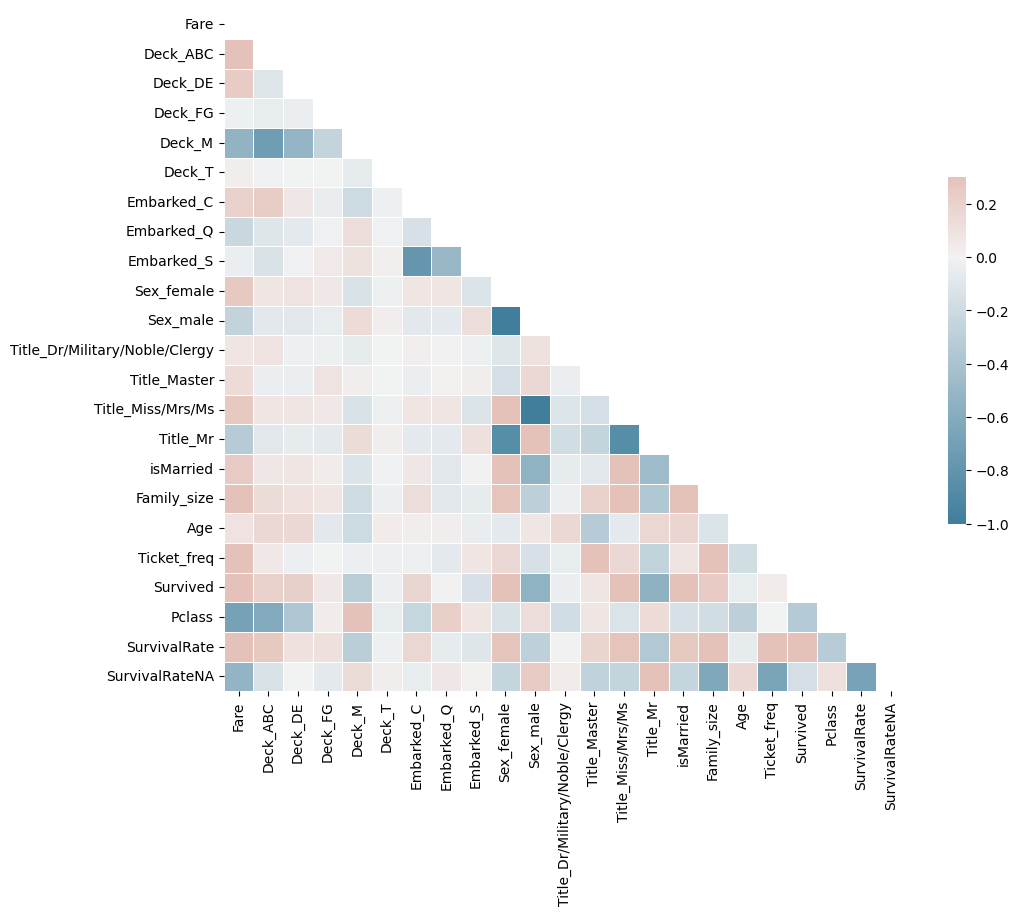

In [228]:
corr = train_df.select_dtypes(exclude=['string']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr,
            mask = mask,
            cmap = cmap,
            vmax = .3,
            center = 0,
            square = True,
            linewidths= .5,
            cbar_kws = {'shrink': .5}
            )

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [230]:
models = {
    'Logistic': LogisticRegression(C=20, penalty='l2', max_iter=5000, n_jobs=-1, random_state=0),
    'DecisionTree': DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, criterion='entropy'),
    'SVM': SVC(kernel='linear',C=10,gamma=.000001)
}

In [231]:
acc_score = {}

for model in models.keys():
    acc_score[model] = cross_val_score(estimator=models[model],X=train_df.drop(columns=['Survived']),y=train_df['Survived'],cv=10,n_jobs=16,scoring='accuracy').mean()

acc_score

{'Logistic': np.float64(0.883270911360799),
 'DecisionTree': np.float64(0.8697877652933833),
 'RandomForest': np.float64(0.8754307116104869),
 'SVM': np.float64(0.8798876404494382)}

In [232]:
rf = RandomForestClassifier(n_estimators=100,oob_score=True, random_state=0)
scores = cross_val_score(estimator=rf, X=train_df.drop(columns='Survived'), y=train_df['Survived'], cv=10, n_jobs=16, scoring = "accuracy")
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Mean: 0.8753932584269662
Standard Deviation: 0.0397773439444661


In [233]:
from scipy.stats import randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10,], "min_samples_split" : [2, 4, 10,], "n_estimators": [100,500,11000,1500]}
param_dists = {
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_features": randint(1,len(train_df.columns)),
    "min_samples_leaf": randint(1,20),
    "min_samples_split": randint(2,20),
    "n_estimators": randint(10, 5000),
    "max_depth": randint(1, 20)
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dists,
    n_iter=300,
    n_jobs=16,
    scoring='accuracy',
    refit=True,
    random_state=42
)

randomized_search.fit(train_df.drop(columns=['Survived']),train_df['Survived'])

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   n_iter=300, n_jobs=16,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5b257c9e80>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5bbcaf0cb0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5b259a7fb0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5b257c9b20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5b257cb3e0>},
                   random_state=42, scoring='accuracy')

In [234]:
random_forest_tuned = RandomForestClassifier(criterion='log_loss',
                                             min_samples_leaf=2,
                                             min_samples_split=9,
                                             n_estimators=404,
                                             random_state=42,
                                             max_features=16,
                                             max_depth=6,
                                             oob_score=True,
                                             n_jobs=16)

score = cross_val_score(random_forest_tuned,train_df.drop(columns=['Survived']),train_df['Survived'],scoring='accuracy',cv=10,n_jobs=16)
random_forest_tuned.fit(train_df.drop(columns=['Survived']),train_df['Survived'])

print(f'Cross-validated accuracy score: {round(score.mean(),4)*100} ({round(score.std(),4)*100}) % ')

Cross-validated accuracy score: 88.21 (3.34) % 


In [242]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

predictions = cross_val_predict(random_forest_tuned, train_df.drop(columns=['Survived']), train_df['Survived'], cv=10, n_jobs=16)
print(confusion_matrix(train_df['Survived'], predictions))
print(f'Precison: {precision_score(train_df['Survived'], predictions)}')
print(f'Recall: {recall_score(train_df['Survived'], predictions)}')
print(f'F1-Score: {f1_score(train_df['Survived'], predictions)}')

[[513  36]
 [ 69 273]]
Precison: 0.883495145631068
Recall: 0.7982456140350878
F1-Score: 0.8387096774193549


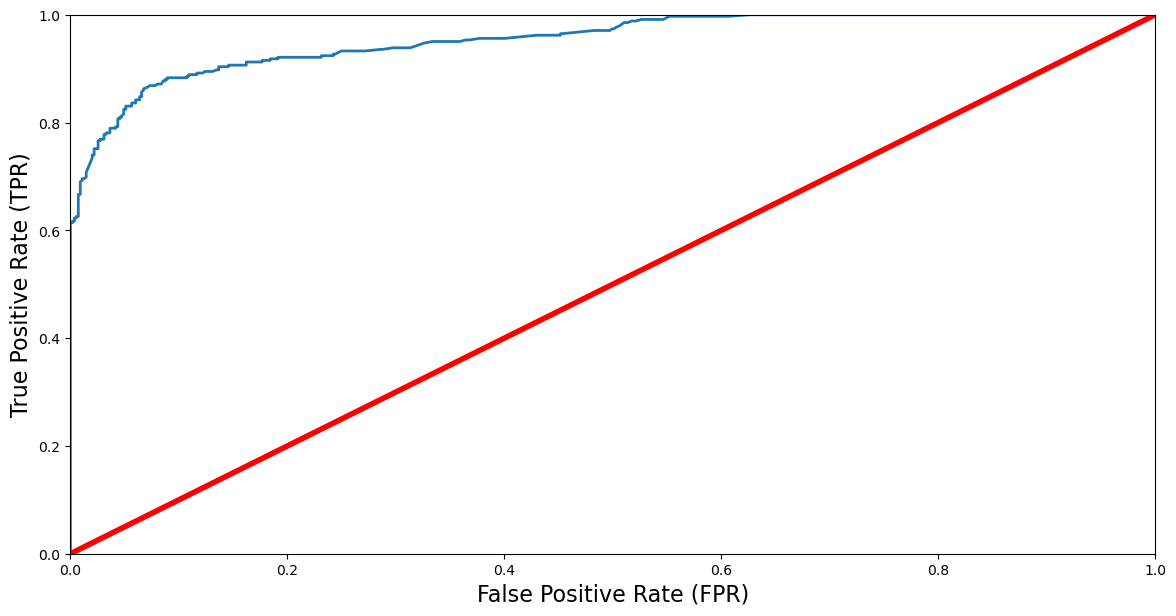

In [243]:
from sklearn.metrics import roc_curve

y_scores = random_forest_tuned.predict_proba(train_df.drop(columns=['Survived']))
y_scores = y_scores[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(train_df['Survived'], y_scores)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)
    
plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [244]:
from sklearn.metrics import roc_auc_score

r_a_score = roc_auc_score(train_df['Survived'], y_scores)
print(f'ROC-AUC-Score: {r_a_score}')

ROC-AUC-Score: 0.9538341908200982


In [246]:
test_df.drop(columns=['Survived'], inplace=True)
submission_df = pd.DataFrame(random_forest_tuned.predict(test_df).astype(dtype=int),index=test_df.index,columns=['Survived'])
submission_df.to_csv(data_path+'submission_t.csv')